# Case 3 - Medical text categorization
Jenni Hautojärvi   
Last edited: 11.3.2018   
Cognitive Systems for Health Technology Applications   
Helsinki Metropolia University of Applied Sciences  

# 1. Objectives
In this assignment the main goal was to get familiar how to use recurrent (RNN) and 1D convolutional neural networks (CNN) to categorize medical texts. As in RNN I used LSTM.

# 2. Import libraries

In [2]:
import os
import itertools

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

# 3. Processing raw data

Data is from [Ohsumed collection](http://disi.unitn.it/moschitti/corpora.htm). It includes medical abstracts from the MeSH categories of the year 1991. There is 20,000 documents divided in 10,000 for training and 10,000 for testing. Documents contain 23 cardiovascular diseases categories.

Categories:

- C01 Bacterial Infections and Mycoses 
- C02 Virus Diseases                                  
- C03 Parasitic Diseases                                
- C04 Neoplasms     
- C05 Musculoskeletal Diseases                                
- C06 Digestive System Diseases                               
- C07 Stomatognathic Diseases                                 
- C08 Respiratory Tract Diseases                            
- C09 Otorhinolaryngologic Diseases
- C10 Nervous System Diseases                               
- C11 Eye Diseases                                          
- C12 Urologic and Male Genital Diseases                    
- C13 Female Genital Diseases and Pregnancy Complications   
- C14 Cardiovascular Diseases                               
- C15 Hemic and Lymphatic Diseases                          
- C16 Neonatal Diseases and Abnormalities                   
- C17 Skin and Connective Tissue Diseases                   
- C18 Nutritional and Metabolic Diseases                    
- C19 Endocrine Diseases                                    
- C20 Immunologic Diseases                                  
- C21 Disorders of Environmental Origin                     
- C22 Animal Diseases                                       
- C23 Pathological Conditions, Signs and Symptoms           

Here date is read and listed it based on 6.8 (p. 189) Chollet: Deep Learning with Python, 2018.

In [3]:
#Download the training data and the labels

case_dir = 'ohsumed-first-20000-docs'
train_dir = os.path.join(case_dir, 'training')

labels = []
texts = []

label_list = ['C{:02}'.format(n) for n in range(1, 23 + 1)]

for label_type in label_list:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        labels.append(label_list.index(label_type))

# 4. Tokenize the text of the raw data

Here we set same length for all samples and choose how many words we inclued in the  vocabulary. The vocabulary is often limited to a certain maximum number of most frequently encountered words.

We also Tokenizer the data. In Tokenize it turn text samples (strings) into lists of integer indices for words. Because all machine learning algorithms, neural networks only deal with numbers. Therefore, samples containing text need to be preprocessed into tensors of numbers. By default, the tokenization is on word level separated by ” ”, converts to lowercase, and involves filtering out special characters: !"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n

Here listing is based on 6.9 (p. 189) Chollet: Deep Learning with Python, 2018. 

In [4]:
#Preprocess word data into integer tensors
#Only "max_words" most frequent words are taken into account

maxlen = 300 # Cut reviews after 300 words (common length of all the samples)
max_words = 20000 # Only consider the top 20,000 words in the dataset

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


# 5. Shape the data and labels

Using padding ensures that all the lists are of the same length by adding zeros. The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras.

- [Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

In [5]:
#Each sample is zero-padded to length "maxlen"
#Preprocess integer labels into one-hot tensor labels

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)

print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 300)
Shape of labels tensor: (10433, 23)


Here we can see we have 10 433 corresponding integer in the lists after tokenization.

# 6. Shuffle the data and labels

Here we shuffle the data because it is safer if the examples are first put in a random order. It is important for efficiency of the estimator that each example be sampled approximately independently, so we can't repeat the examples in the same order on a second epoch.

Bengio, Yoshua. "Practical recommendations for gradient-based training of deep architectures." Neural Networks: Tricks of the Trade. Springer Berlin Heidelberg, 2012. 437-478.

In [6]:
#Shuffle the training data 

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

# 7. Build the model

First in the I used word Embedding that uses 32 length vectors to represent each word. In the model I used also 1D CNN and LSTM. I also used 0.1 dropping.

In [7]:
#Build and compile the network model

model = Sequential()
model.add(Embedding(max_words, 32, input_shape=(maxlen,)))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(len(label_list), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                2323      
Total params: 698,627
Trainable params: 698,627
Non-trainable params: 0
_________________________________________________________________


# 8. Train the model

In [8]:
#Fit the model to training data using 0.1 validation split

history = model.fit(data, one_hot_labels, epochs = 20, batch_size = 30,
                   validation_split=0.1)

Train on 9389 samples, validate on 1044 samples
Epoch 1/20
9389/9389 [==============================] - 135s 14ms/step - loss: 2.8272 - acc: 0.1635 - val_loss: 2.7569 - val_acc: 0.1743
Epoch 2/20
9389/9389 [==============================] - 119s 13ms/step - loss: 2.5993 - acc: 0.2397 - val_loss: 2.5406 - val_acc: 0.2634
Epoch 3/20
9389/9389 [==============================] - 118s 13ms/step - loss: 2.4423 - acc: 0.2708 - val_loss: 2.5629 - val_acc: 0.2596
Epoch 4/20
9389/9389 [==============================] - 117s 12ms/step - loss: 2.3429 - acc: 0.2915 - val_loss: 2.4715 - val_acc: 0.2739
Epoch 5/20
9389/9389 [==============================] - 117s 13ms/step - loss: 2.2652 - acc: 0.3104 - val_loss: 2.5055 - val_acc: 0.2510
Epoch 6/20
9389/9389 [==============================] - 119s 13ms/step - loss: 2.1985 - acc: 0.3316 - val_loss: 2.5078 - val_acc: 0.2625
Epoch 7/20
9389/9389 [==============================] - 125s 13ms/step - loss: 2.1346 - acc: 0.3522 - val_loss: 2.5438 - val_acc: 

# 9. Training result

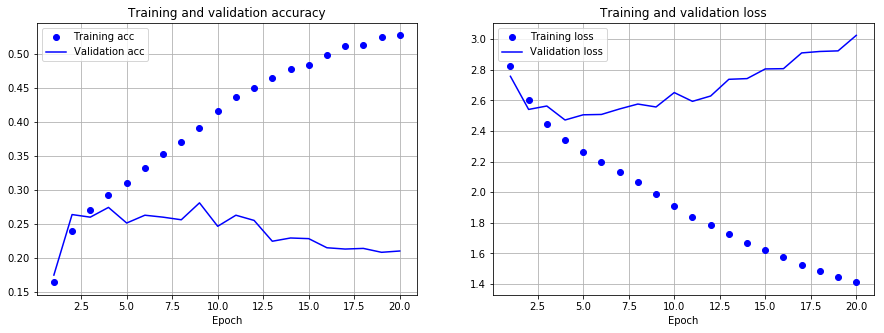

In [9]:
#Plot the results

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

I tried many versions of the model but this was the best were the validation accuracy was above 20%. I notised that when you ingreased batch size (like 50 or 60) the validation accucacy was lower and validation loss get bigger. I also tried whitout dropping but using 10% dropping the results were better.

In this model the training accuracy is close 53% and validation accuracy is above 20%. And validation loss is just little above 3.0.

# 10. Metrics results

In [10]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

## Classification report
Precision is the number of correct positive results divided by the number of all positive results returned by the classifier.

Recall is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive)

F1 score is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score. The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

In [11]:
# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.45      0.57      0.51       423
          1       0.35      0.22      0.27       158
          2       0.50      0.26      0.34        65
          3       0.56      0.76      0.65      1163
          4       0.53      0.39      0.45       283
          5       0.61      0.52      0.56       588
          6       0.84      0.21      0.34       100
          7       0.44      0.54      0.49       473
          8       0.56      0.28      0.37       125
          9       0.63      0.45      0.52       621
         10       0.61      0.41      0.49       162
         11       0.55      0.63      0.59       491
         12       0.53      0.41      0.46       281
         13       0.61      0.76      0.68      1249
         14       0.39      0.14      0.21       215
         15       0.41      0.36      0.39       200
         16       0.51      0.46      0.49       295
         17       0.68      0.54      0.60   

From this model we get avg precision 0.54, recall 0.54 and F1 0.53. Because good result of F1 is 1 and bad is 0. So the model is not very good but it's not very bad either, because we are somewhere in the middle.

[[243  12   0   7   0  19   1  26   0   6   1   3   2  11   0   0   1   1   0  33  17   0  40]
 [ 19  34   2   8   0   3   0   2   1   3   0   0   3   3   0   0   0   0   1  73   0   0   6]
 [ 10   3  17   1   0   2   0   5   0   1   3   1   2   2   0   0   2   1   0  12   0   0   3]
 [  3   2   0 886   1  20   2  33   5   6   2  52   7  10   1   8   8   3  12  43   8   0  51]
 [ 12   1   1  11 109   3   1  19   2   9   2   0   0   5   1   5  14   4   3   5  34   0  42]
 [ 30   2   1  63   1 307   0   3   0   2   0  14   6   5   1   0   0   7   3  19  15   1 108]
 [  4   3   0  27   5   1  21   3   2   0   0   0   2   1   1   2   9   0   3   8   2   0   6]
 [ 16   2   0  50   1   4   0 254   4   4   1   2   1  16   1   0   4   1   0  65   3   1  43]
 [  3   1   0  32   0   0   0  11  35   1   0   1   2   0   2   1   9   0   0  10   1   0  16]
 [ 20   0   0  37  10   4   0  12   1 277   3   5   6  46   1   6   2   8   4  21  23   0 135]
 [  8   2   2  16  15   1   0   3   0   2  66   1 

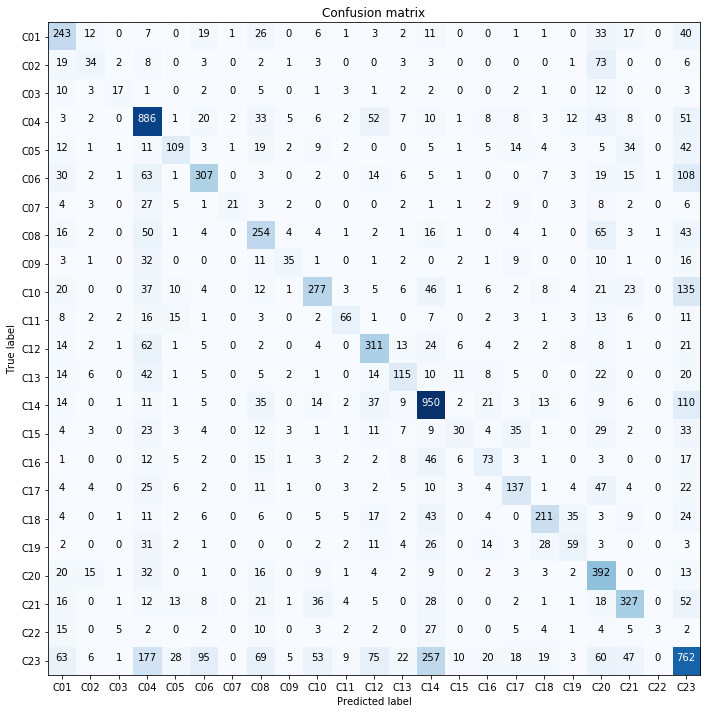

In [12]:
# Confusion matrix

cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 100))

plt.clf()
plt.figure(figsize=(12,12))
plt.imshow(cm , interpolation='nearest', cmap= plt.cm.Blues)
classNames = label_list
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

This confusion matrix is very hard to read because it so big. Confusion matrix size is 23x23 because there is 23 cardiovascular diseases categories. In the matrix the rowns presents True labels and columns are Predicted labels. Crossing from the left up to right down we can see how many values was the same in true and predicting. And from the colors also we can see that the crossing values are the biggest, which is the true-positive value.

In [13]:
print(texts[indices[512]])

Multimodality preoperative treatment for advanced stage IV (MO) cancer of the head and neck.
 Sixty-three patients with advanced unresectable squamous cell carcinoma of the head and neck were treated with a combination of chemotherapy, radiation, and surgery.
 We observed a 75% response to neoadjuvant chemotherapy.
 The 5-year survival rate for all 63 patients was 20%, and only 3 patients were alive at 8 years.
 The 5-year survival rate for patients who completed the treatment plan and received chemotherapy, radiation, and surgery was 43% compared with 20% for those who had chemotherapy and radiation but refused surgery.
 Development of a second primary cancer was the cause of death in 62% of the patients who survived more than 24 months.



True class:  3
Predicted class: 3
Predictions per class:
[  1.50e-03   1.37e-03   2.86e-04   8.59e-01   1.36e-03   7.32e-03
   2.66e-03   2.49e-02   5.11e-03   7.18e-03   3.07e-03   3.00e-04
   1.58e-03   5.00e-04   5.09e-03   2.65e-04   3.46e-03   4.55e-04
   3.96e-04   8.61e-03   3.62e-03   2.15e-04   6.17e-02]


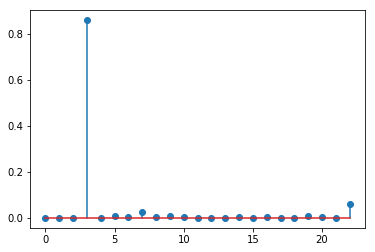

In [14]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

From the predictions per class we can see that it fould actyally be in class C4 and from the list we can see it is Neoplasms. I think here we get class 3 because python starts counting from 0 not from 1. From the show we can see that it's the highest value.

# 11. Test the model

In [15]:
#Download and preprocess test data

test_dir = os.path.join(case_dir, 'test')

test_labels = []
test_texts = []

for label_type in label_list:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        test_texts.append(f.read())
        f.close()
        test_labels.append(label_list.index(label_type))

test_sequences = tokenizer.texts_to_sequences(test_texts)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
test_labels = np.asarray(test_labels)
y_test = to_categorical(test_labels)

In [16]:
#Evaluate model with test data

eva = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" %(eva[1]*100))
print("Loss: %.2f%%" %(eva[0]*100))

12733/12733 [==============================] - 35s 3ms/step
Accuracy: 32.10%
Loss: 251.39%


This model testing gave the highest accuracy 32% and lowest loss 251%. Not very good, but it was the best whit my skills.

# 12. Conclutions

Accuracy and loss values were not the best, but from the confusion matrix and F1 we saw the model work. However, I would not use this to classify the texts of the right patients. I tried chancing model (layers and dropping), batch size, epochs, maxlen and max_words, but this what I present was the best result I got.

This assigment was a very good even with a bad results because the aim was to get the familiar of text classification by using RNN and CNN and I believe I have achieved it. I learned a lot from this assigment and I know now how CNN can be used when the data is in text format.